# CSCA 5642 Week 4 NLP Disaster Mini-Project

## Problem Description
The aim of this project is to build a deep learning model trained on text data ("Tweets") to determine whether the text explicitly describes a real disaster or is simply using disaster-related terms in other contexts e.g. metaphorically. Certain English terms can be used in a variety of situations, so the challenge is to distinguish between the literal use of disaster-related terms and non-literal use. The dataset is available via the [Natural Language Processing with Disaster Tweets Kaggle Competition](https://www.kaggle.com/c/nlp-getting-started/overview).

This notebook contains the pipeline for data loading/processing, EDA, model training, and inference. The score for the inference results are given by the Kaggle submission score.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertModel, BertTokenizer
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pack_padded_sequence

from nlp_dataset import NLPDataset

In [2]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name()}")
else:
    print(f"No available GPU.")

Available GPU: NVIDIA GeForce RTX 3070 Ti


## Exploratory Data Analysis
The dataset contains 2 main files:
* `train.csv`: training examples containing the Tweet (`text`) and label (`target`)
* `test.csv`: test examples for inference (unlabeled)

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The labels in the `train` set are given by the column `target`, where:
* `1`: real disaster
* `0`: not real disaster

### Class Distribution

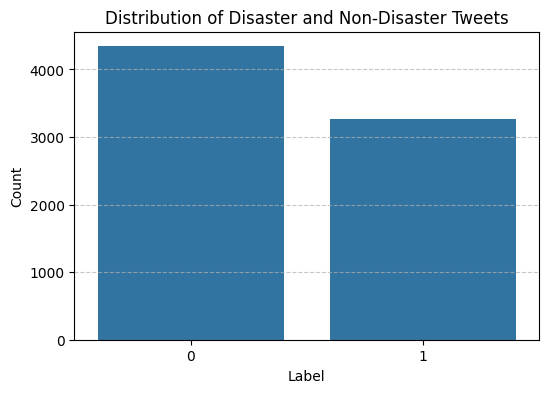

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='target')
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The distribution of Tweet types is skewed towards non-disaster Tweets, though relatively close.

### Text statistics

**Most common words using TD-IDF**

We will use `Term Frequency-Inverse Document Frequency (TF-IDF)` to determine the most common words in the text, adjusted for common English terms that do not necessarily provide context e.g. `the`, `to`, `and`.

In [7]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf = vectorizer.fit_transform(train["text"])

train_tfidf = vectorizer.transform(train["text"])

scores = np.sum(train_tfidf.toarray(), axis=0)
tfidf_df = pd.DataFrame({"Token": vectorizer.get_feature_names_out(),
                         "Score": scores})

print("Top 10 Most Common Words")
tfidf_df.sort_values(by="Score", ascending=False).head(10)

Top 10 Most Common Words


,Token,Score
9192,http,313.289011
9193,https,74.062672
11323,like,67.888804
10427,just,63.006080
1939,amp,55.128828
21307,û_,51.044426
5970,don,42.351847
13036,new,41.541058
14216,people,40.901743
13050,news,37.697347


The most common terms (`Token`) are `http` and `https`, which is likely due to link sharing / retweets, which generally contain text starting with `http`. It may be useful to look at the most common words among the two categories of tweets.

In [8]:
disaster_train = train[train["target"] == 1]
non_disaster_train = train[train["target"] == 0]

disaster_tfidf = vectorizer.transform(disaster_train["text"])
non_disaster_tfidf = vectorizer.transform(non_disaster_train["text"])

In [9]:
disaster_scores = np.sum(disaster_tfidf.toarray(), axis=0)
disaster_tfidf_df = pd.DataFrame({"Token": vectorizer.get_feature_names_out(),
                         "Score": disaster_scores})

print("Top 10 Most Common Words in Disaster Tweets")
disaster_tfidf_df.sort_values(by="Score", ascending=False).head(10)

Top 10 Most Common Words in Disaster Tweets


,Token,Score
9192,http,174.446192
13050,news,27.278950
3746,california,26.357289
21307,û_,25.296165
5779,disaster,25.245636
17896,suicide,23.930097
9193,https,23.020113
8969,hiroshima,22.333531
14557,police,21.008892
10706,killed,20.679084


In [10]:
non_disaster_scores = np.sum(non_disaster_tfidf.toarray(), axis=0)
non_disaster_tfidf_df = pd.DataFrame({"Token": vectorizer.get_feature_names_out(),
                         "Score": non_disaster_scores})

print("Top 10 Most Common Words in Non-Disaster Tweets")
non_disaster_tfidf_df.sort_values(by="Score", ascending=False).head(10)

Top 10 Most Common Words in Non-Disaster Tweets


,Token,Score
9192,http,138.842819
9193,https,51.042559
11323,like,49.633020
10427,just,46.904227
1939,amp,34.627777
5970,don,31.487495
13036,new,31.212716
21307,û_,25.748262
3232,body,25.316395
11570,love,23.983045


Ignoring terms like `http` or `https`, common disaster-related terms do appear frequent in true disaster tweets. Interestingly, `California` is a top word in disaster tweets. This is possibly due to California having the most [wildfires](https://www.iii.org/fact-statistic/facts-statistics-wildfires#:~:text=According%20to%20the%20National%20Interagency,most%20destructive%2C%20and%20deadliest%20wildfires.) out of every state in the United States, and wildfires typically fall under the disaster category.

## Data Cleaning

### Remove URLs/special characters, tokenize text

In [11]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) 
    text = re.sub(r"\s+", " ", text).strip()
    return text

### Tokenizer
We will load a pre-built tokenizer from `BERT` (Bidirectional Encoder Representations from Transformers), a pre-trained language model built on the transformer architecture (introduced in the paper [Attention is All You Need (2017)](https://arxiv.org/abs/1706.03762). Pre-trained models can be loaded from the `transformers` library. For this model, we will use the `bert-base-uncased` model.

In [12]:
def get_tokenizer(bert_model):
    return BertTokenizer.from_pretrained(bert_model)

bert_tokenizer = get_tokenizer("bert-base-uncased")

We will write a custom `torch` dataset, which will have a `train` or `test` mode. For training, we will need to include the labels. For inference, we will need to format the test set (which has no labels) into the same dataset format. The `Dataset` class will process the tokens, and since the inputs in each batch need to be the same length, we will pad each sequence of tokens to a max length (or truncate if the sequence length exceeds the preset max length). `BERT` specifically can handle a max length of 512, but this is not necessarily an appropriate choice, since most sequences are not this length. From looking at NLP resources, specifically models related to Tweets, a common choice was `max_length = 120`. We will also use `attention_mask` for the model to distinguish between padded and true tokens.

A note about the `Dataset` class is using a custom class may cause an `AttributeError` if using multiprocessing while run on a notebook. The workaround for this is to save the code (and any dependencies) into a separate Python file and importing the function from the file.

In [13]:
class NLPDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None, max_len=120, mode="train"):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.mode = mode

    def get_tokens(self, text, max_len):
        text = preprocess(text)
        tokens = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_len)
        pad_length = max_len - len(tokens)
        if pad_length > 0:
            tokens += [self.tokenizer.pad_token_id] * pad_length
        mask = [1 if idx < len(tokens) - pad_length else 0 for idx in range(len(tokens))]
        return tokens, mask

    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        tokens, mask = self.get_tokens(self.texts[idx], self.max_len)
        input_ids = torch.tensor(tokens, dtype=torch.long)
        attention_mask = torch.tensor(mask, dtype=torch.long)
        seq_len = (attention_mask == 1).sum().item()

        if self.mode == "train":
            label = self.labels[idx]
            return [input_ids, attention_mask, seq_len], torch.tensor(label, dtype=torch.float)

        return [input_ids, attention_mask, seq_len]

## Model Development

### Architecture
Our model will be built on the `torch` framework calling a pretrained `BERT` model. The `NLPModel` will include an `LSTM` layer (Long Short-Term Memory Networks), which will be used to capture sentiment information on the sequences of tokens (for our case, sentiment related to disasters).

In [14]:
class NLPModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, 1)

    def forward(self, inputs):
        input_ids, attention_mask, lengths = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encoded_layers = outputs.last_hidden_state
        
        packed = pack_padded_sequence(encoded_layers, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)

        output_hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        output_hidden = F.dropout(output_hidden, 0.2)
        output = self.classifier(output_hidden)
        return torch.sigmoid(output)

### Training

In [15]:
def load_data(tokenizer, train_df, batch_size=32, max_len=120):
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df["text"].values, train_df["target"].values,
        test_size=0.2, random_state=42, stratify=train_df["target"].values
    )
    
    train_dataset = NLPDataset(tokenizer, train_texts, train_labels, max_len, mode="train")
    val_dataset = NLPDataset(tokenizer, val_texts, val_labels, max_len, mode="train")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [16]:
def run_training(
    model_name="bert-base-uncased", train_df=None, batch_size=32, epochs=5, lr=2e-5, max_len=120):
    tokenizer = get_tokenizer(model_name)
    train_loader, val_loader = load_data(tokenizer, train_df, batch_size=batch_size, max_len=max_len)

    model = NLPModel(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.90)
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")

        for batch in pbar:
            (input_ids, attention_mask, seq_lens), labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            seq_lens = seq_lens.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model([input_ids, attention_mask, seq_lens]).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = (outputs > 0.5).long()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_loss += loss.item()

            del loss, outputs
            torch.cuda.empty_cache()

        train_acc = (torch.tensor(train_preds) == torch.tensor(train_labels).long()).float().mean().item()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
                (input_ids, attention_mask, seq_lens), labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                seq_lens = seq_lens.to(device)
                labels = labels.to(device)

                outputs = model([input_ids, attention_mask, seq_lens]).squeeze(1)
                loss = criterion(outputs, labels)

                preds = (outputs > 0.5).long()
                val_preds.extend(preds.cpu().numpy())
                val_labels_.extend(labels.cpu().numpy())
                val_loss += loss.item()

                del loss, outputs
                torch.cuda.empty_cache()

        val_acc = (torch.tensor(val_preds) == torch.tensor(val_labels).long()).float().mean().item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1} Results:")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Val Loss:   {val_losses[-1]:.4f}, Val Acc:   {val_accuracies[-1]:.4f}")
        print("-" * 50)

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [17]:
model = run_training(model_name="bert-base-uncased",
                     train_df=train,
                     batch_size=64,
                     epochs=10,
                     lr=2e-5,
                     max_len=120)

Epoch 1 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.53it/s]


Epoch 1 Results:
Train Loss: 0.4754, Train Acc: 0.7768
Val Loss:   0.3689, Val Acc:   0.8496
--------------------------------------------------


Epoch 2 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.97it/s]


Epoch 2 Results:
Train Loss: 0.3390, Train Acc: 0.8672
Val Loss:   0.3769, Val Acc:   0.8523
--------------------------------------------------


Epoch 3 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.98it/s]


Epoch 3 Results:
Train Loss: 0.2638, Train Acc: 0.9021
Val Loss:   0.4266, Val Acc:   0.8385
--------------------------------------------------


Epoch 4 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.52it/s]


Epoch 4 Results:
Train Loss: 0.2056, Train Acc: 0.9258
Val Loss:   0.4327, Val Acc:   0.8431
--------------------------------------------------


Epoch 5 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.00it/s]


Epoch 5 Results:
Train Loss: 0.1419, Train Acc: 0.9479
Val Loss:   0.4963, Val Acc:   0.8345
--------------------------------------------------


Epoch 6 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.99it/s]


Epoch 6 Results:
Train Loss: 0.1081, Train Acc: 0.9616
Val Loss:   0.5640, Val Acc:   0.8319
--------------------------------------------------


Epoch 7 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.97it/s]


Epoch 7 Results:
Train Loss: 0.0821, Train Acc: 0.9686
Val Loss:   0.5996, Val Acc:   0.8168
--------------------------------------------------


Epoch 8 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.99it/s]


Epoch 8 Results:
Train Loss: 0.0640, Train Acc: 0.9780
Val Loss:   0.6476, Val Acc:   0.8201
--------------------------------------------------


Epoch 9 [Validation]: 100%|████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.96it/s]


Epoch 9 Results:
Train Loss: 0.0548, Train Acc: 0.9810
Val Loss:   0.7500, Val Acc:   0.8188
--------------------------------------------------


Epoch 10 [Validation]: 100%|███████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.97it/s]

Epoch 10 Results:
Train Loss: 0.0484, Train Acc: 0.9810
Val Loss:   0.7452, Val Acc:   0.8227
--------------------------------------------------


In [18]:
# save model
# torch.save(model, "models/model.pth")

torch.save(model[0].state_dict(), "models/bert_model_weights_rev3.pth")

train_losses = model[1]
val_losses = model[3]
val_accuracies = model[4]

metrics_df = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses)+1)),
    "Train Loss": train_losses,
    "Val Loss": val_losses,
    "Val Accuracy": val_accuracies
})

metrics_df.to_csv("training_metrics.csv", index=False)

### Inference

In [19]:
test_dataset = NLPDataset(tokenizer=bert_tokenizer, texts=test["text"].values, max_len=120, mode="test")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NLPModel(model_name="bert-base-uncased")
model.load_state_dict(torch.load("models/bert_model_weights_rev3.pth"))
model = model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, seq_lens = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        seq_lens = seq_lens.to(device)

        outputs = model([input_ids, attention_mask, seq_lens])
        outputs = outputs.squeeze(1) 
        preds = (outputs > 0.5).long() 
        predictions.extend(preds.cpu().numpy())


submission_df = pd.DataFrame({
    "id": test["id"],
    "target": predictions
})
submission_df.to_csv("submission3.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:07<00:00, 13.42it/s]


### Results

### Kaggle Submission Scores
* Model 1 (`batch_size` = 32, `epochs` = 5, `lr` = 2e-5)
  
![Kaggle Submission](scores/score1.png)

_______________________________________________________________________________________________________________________________________________________
* Model 2 (`batch_size` = 32, `epochs` = 10, `lr` = 2e-5)

![Kaggle Submission](scores/score2.png)
_______________________________________________________________________________________________________________________________________________________
* Model 3 (`batch_size` = 64, `epochs` = 10, `lr` = 2e-5)

![Kaggle Submission](scores/score3.png)
_______________________________________________________________________________________________________________________________________________________

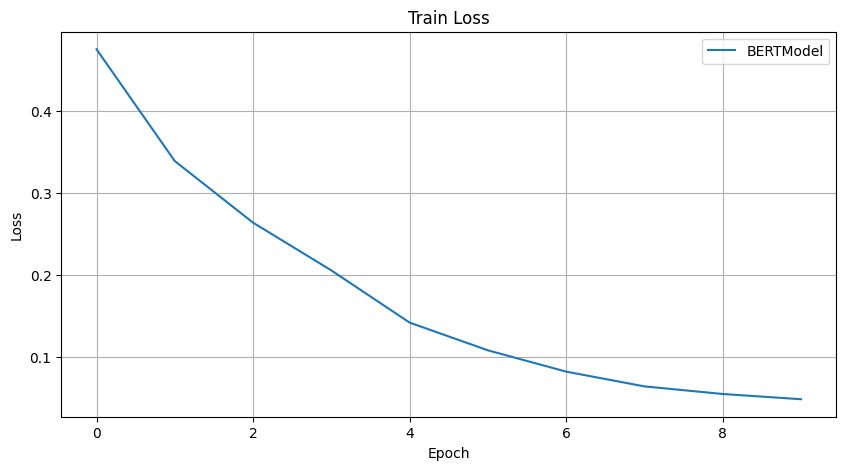

In [23]:
metrics = pd.read_csv("training_metrics.csv")
plt.figure(figsize=(10, 5))
plt.plot(metrics['Train Loss'], label="BERTModel")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

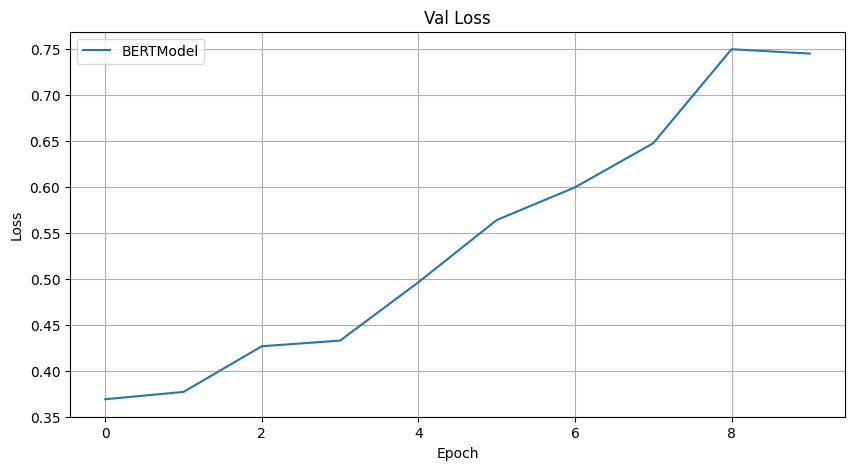

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['Val Loss'], label="BERTModel")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss")
plt.legend()
plt.grid(True)
plt.show()

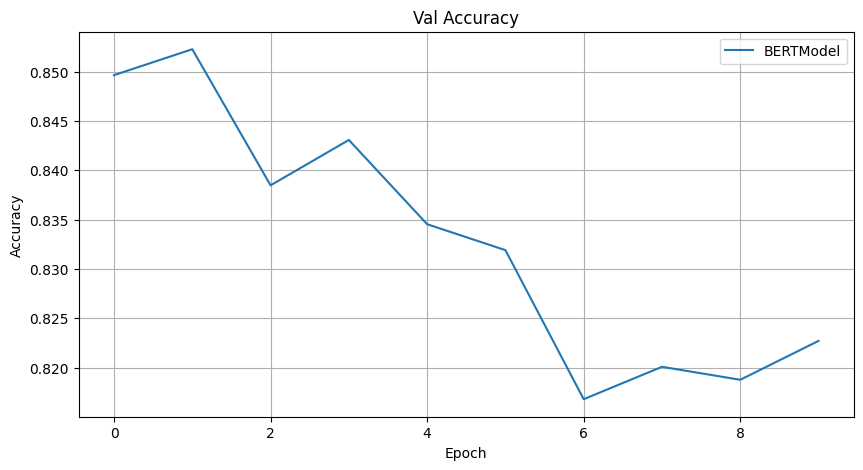

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['Val Accuracy'], label="BERTModel")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Summary of Results

|`Model Run`|`batch_size`|`epochs`|  `lr`  |`acc_score`|
|-----------|------------|--------|--------|-----------|
|     1     |     32     |   5    |  2e-5  |  0.82347  |
|     2     |     32     |   10   |  2e-5  |  0.80570  |
|     3     |     64     |   10   |  2e-5  |  0.81489  |

The highest accuracy score achieved by the model on the Kaggle submission was `0.82347`. All 3 submissions performed similarly, with the initial model slightly outperforming the other models by ~1-2%. The same model was used for all submissions, with variation in the `batch_size` and `epochs`. Comparing the first 2 submissions, increasing the number of epochs did not improve accuracy on inference. The score actually decreased, which could possibly be caused by the model overfitting on the training data. Specifically, training on higher epochs could have led to the model to memorize specific instances of the data in the weights, leading to overfitting. I attempted to mitigate this by increasing the batch size while keeping the same number of epochs. The score was still lower than the initial model's score, but it did improve over the model with increased epochs with no adjusted batch size.

One thing I noticed in the Kaggle leaderboard for this specific competition was a significant number of entries hovering the same score range (~80-90%), with relatively few above 90%. From browsing the discussions, it appears that some of the higher scores are due to a data leak, meaning the submissions were made based on access to the ground truth and not actual model predictions.

### Conclusion

Something I learned from this specific competition was the significance of the learning rate hyperparameter. I mostly have experience training models on image data and typically choose relatively large learning rates e.g. `1-e3`. When I worked on this NLP model, I initially had very poor training and validation results (<60% accuracy), and from doing a Google search, I found that NLP models, specifically a pre-trained `BERT` model requires much smaller learning rates to properly fine-tune the weights. The train time did noticeably increase a little over 2x, but the training and validation accuracies increased to ~80-85%.

## References
* https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial
* https://huggingface.co/docs/transformers/en/installation
* https://pytorch.org/
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://huggingface.co/docs/transformers/en/model_doc/bert